# Objectives

1. Run clock analysis.
1. Add clock stats to dataframe.
1. Plot root-to-tip regression with date (tips+internals)
1. Plot timetree.
1. Plot subtrees.
1. Plot map.

**TO-DO**:

1. Refine timetree parameters, specifically:
    - Relaxed clock
    - Marginal date estimation and confidence
1. Visualize rates on timetree

---
# Setup

## Import Modules

In [1]:
import treetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches, lines, gridspec, colors
from matplotlib.path import Path
from Bio import Phylo, AlignIO
import os
import io
import sys
import numpy as np
import pandas as pd
import random
import math
import copy
import scipy
#import augur
import plotly

import shapely.geometry
import geopandas
import augur

# Install these
import bezier


## Input file paths

In [2]:
tree_path = "../../docs/results/latest/parse_tree/parse_tree.nwk"
tree_df_path = "../../docs/results/latest/mugration/mugration.tsv"
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"
constant_sites_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.full.constant_sites.txt"
outdir = "../../docs/results/latest/timetree/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

NAME_COL = "Name"
SCRIPT_NAME = "timetree"

# Random
random.seed(1152342, 2)
np.random.seed(70262122)
st0 = np.random.get_state()


plt.rc('lines', linewidth=2)
plt.rc('legend', labelspacing=0.75)
plt.rc('legend', frameon=False) # legend frame

# Mugration
MUG_ATTR = "Branch_Major"
GEO_ATTR = "Province"

pd.set_option("display.max_rows", 10, "display.max_columns", None)

## Add constant sites to the snp alignment
MEMORY PERMMITING!

In [4]:
align = AlignIO.read(aln_path, format="fasta")

In [5]:
"""constant_sites_dict = {"A": 0, "C" : 0, "G" : 0, "T" : 0}

with open(constant_sites_path, "r") as infile:
    constant_sites_list = infile.read().strip().split(",")
    constant_sites_dict["A"] = int(constant_sites_list[0])
    constant_sites_dict["C"] = int(constant_sites_list[1])
    constant_sites_dict["G"] = int(constant_sites_list[2])
    constant_sites_dict["T"] = int(constant_sites_list[3])    

print(constant_sites_dict)
total_constant_sites = sum(constant_sites_dict.values())
print("Constant Sites:", total_constant_sites)

# Add the constant sites to each sample
# Iterate through each samples sequence
for rec in align:
    # Iterate through each nucleotide for constant sites
    for nucleotide,count in constant_sites_dict.items():
        rec.seq = rec.seq + (nucleotide * count)   """   

'constant_sites_dict = {"A": 0, "C" : 0, "G" : 0, "T" : 0}\n\nwith open(constant_sites_path, "r") as infile:\n    constant_sites_list = infile.read().strip().split(",")\n    constant_sites_dict["A"] = int(constant_sites_list[0])\n    constant_sites_dict["C"] = int(constant_sites_list[1])\n    constant_sites_dict["G"] = int(constant_sites_list[2])\n    constant_sites_dict["T"] = int(constant_sites_list[3])    \n\nprint(constant_sites_dict)\ntotal_constant_sites = sum(constant_sites_dict.values())\nprint("Constant Sites:", total_constant_sites)\n\n# Add the constant sites to each sample\n# Iterate through each samples sequence\nfor rec in align:\n    # Iterate through each nucleotide for constant sites\n    for nucleotide,count in constant_sites_dict.items():\n        rec.seq = rec.seq + (nucleotide * count)   '

## Import divergence tree

In [6]:
tree_div = Phylo.read(tree_path, "newick")
tree_div.ladderize(reverse=False)

## Import dataframe

In [7]:
tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)

### Intialize TimeTree Object

In [8]:
# HOT FIX for bad branches
tmp_tree = os.path.join(outdir, "temp.nwk")

bad_samples = ["GCA_008630375.1_ASM863037v1_genomic", 
                "GCA_008630375.2_ASM863037v2_genomic", 
                "GCA_003086075.1_ASM308607v1_genomic",
                "GCA_001613865.1_ASM161386v1_genomic"]

# Prune bad samples from tree and dataframe
for sample in bad_samples:
    tree_div.prune(sample)
    tree_df.drop(index=sample, inplace=True)
    
# Save temp files
tmp_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
tree_df.to_csv(tmp_path_df, sep="\t")

tmp_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
Phylo.write(tree_div, tmp_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

In [9]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(tmp_path_df, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v

# Construct the treetime object
# Remember, including the alignment is crucial!
tt = treetime.TreeTime(dates=dates, 
                       aln=align,                     
                       tree=tmp_path_nwk, 
                       verbose=4, 
                       fill_overhangs=False,
                       seq_len=REF_LEN,                        
                      )

# Remove outliers
tt.clock_filter(reroot=None, 
                n_iqd=N_IQD, 
                plot=False,
               )

# Check rtt
print(tt.date2dist.__dict__)


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.

0.00	-TreeAnc: set-up

0.05	-###TEST.TreeAnc.prepare_tree: BEGIN

1.16	-SequenceData: loaded alignment.
1.16	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.16	-SeqData: making compressed alignment...

3.78	-SequenceData: constructed compressed alignment...
3.86	---**WARNING: Number of tips in tree differs from number of sequences in
    	   alignment!**
4.10	--ClockTree: Setting precision to level 2

4.19	-ClockTree._assign_dates: assigned date contraints to 630 out of 630 tips.
4.54	--ClockTree.date2dist: Setting new molecular clock. rate=9.416e-09,
    	  R^2=0.2483

4.57	-###TEST.TreeAnc.prepare_tree: BEGIN
{'clock_rate': 9.416066712137288e-09, 'intercept': 5.304755152697907e-05, 'chisq': 2.582616029485927e-08, 'r_val': 0.49828866115420706, 'cov': None, 'sigma': 0, 'va

---
# 1. Clock Analysis

In [10]:
# Initialize stdout capture
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout

# PARAM MIN: root='-4101-09-02'
#tt.run()

# PARAM STABLE='-4030-01-03'
# My suspicion is that the branch length mode is the key variable
"""
tt.run(resolve_polytomies=False, 
       Tc="skyline", 
       max_iter=3,
       relaxed_clock={"slack":1.0, "coupling": 0},
       infer_gtr=True,
       )
"""

# PARAM TEST='-4083-05-20'
# My suspicion is that the branch length mode is the key variable
tt.run(resolve_polytomies=False, 
       Tc="skyline", 
       max_iter=MAX_ITER,
       relaxed_clock={"slack":5.0, "coupling": 0},
       infer_gtr=True,
       time_marginal=TIME_MARGINAL,
       sequence_margial=SEQ_MARGINAL,
       )
# PARAM SET X date='-19904-12-03'
"""
tt.run(branch_length_mode = "input",
               n_iqd=3,
               root=None,
               infer_gtr=True,
               resolve_polytomies=False,
               relaxed_clock={"slack":1.0, "coupling": 0},
               max_iter=3,
               Tc="skyline",
               use_covariation=False,
               vary_rate=False,
               time_marginal="assign",
               sequence_marginal=True,
               verbose=4,
              )
"""

# Save stdout to file
output = new_stdout.getvalue()
out_path = os.path.join(outdir, SCRIPT_NAME + ".log") 
with open(out_path, "w") as file:
    file.write(output)
# Restore stdout
sys.stdout = old_stdout
print("Standard output restored.")

Standard output restored.


In [11]:
# Quick check
tt.tree.common_ancestor("NODE0")

Clade(_v=0, bad_branch=False, branch_length=0.0, clock_length=0.0, date='-4152-05-10', dist2root=0.0, mutation_length=0.0, name='NODE0', original_length=0.0)

### Ladderize tree

In [12]:
tt.tree.ladderize(reverse=False)

---
# 2. Add clock stats to data frame

## 'Default' stats

min_gamma:  ['GCA_000182525.1_ASM18252v1_genomic', 0.1]
max_gamma:  ['NODE263', 3.154419810078063]
gamma ratio:  31.54419810078063


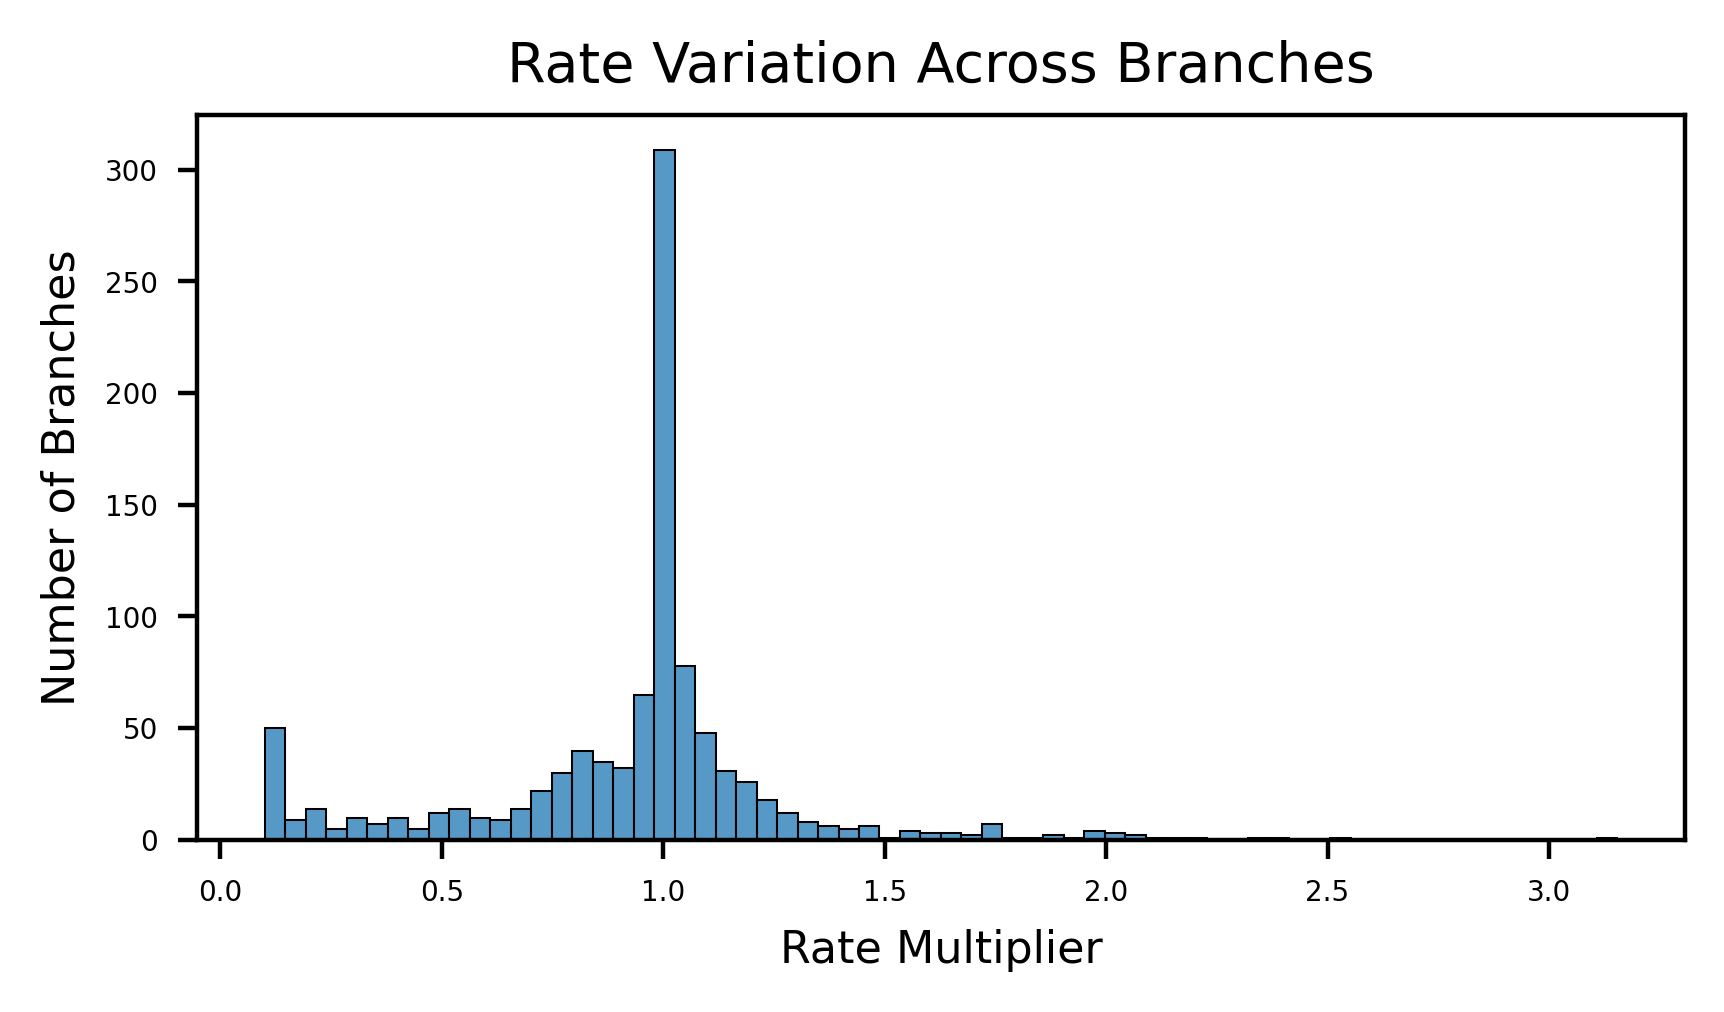

In [13]:
out_path_gtr = os.path.join(outdir, SCRIPT_NAME + "_gtr.txt" )
with open(out_path_gtr, 'w', encoding='utf-8') as outfile:
    outfile.write(str(tt.gtr)+'\n')

# ----------------------------
# Marginal Confidence
if TIME_MARGINAL:
    out_path_dates = os.path.join(outdir, SCRIPT_NAME + "_dates.tsv")

    with open(out_path_dates, "w") as outfile:
        outfile.write('#Lower and upper bound delineate the {0:.0f}% max posterior region\n'.format(CONFIDENCE*100))
        outfile.write('#node\tdate\tnumeric date\tlower bound\tupper bound\n')

        for c in tt.tree.find_clades():
            if c.bad_branch:
                # Should these be NO DATA CHAR instead?
                outfile.write(c.name + "\t" + NO_DATA_CHAR + 
                              "\t" + NO_DATA_CHAR + 
                              "\t" + NO_DATA_CHAR + 
                              "\t" + NO_DATA_CHAR + "\n")
                outfile.write('%s\t--\t--\t--\t--\n'%(c.name))
            else:
                conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE) 
                outfile.write('%s\t%s\t%f\t%f\t%f\n'%(c.name, c.date, c.numdate,conf[0], conf[1]))
                
# ----------------------------
# Rate Variation
if RELAXED_CLOCK:
    min_gamma = ['', 1]
    max_gamma = ['', 1]
    gamma_dict = {}

    out_path_rates = os.path.join(outdir, SCRIPT_NAME + "_rates.tsv")
    with open(out_path_rates, "w") as outfile:
        outfile.write("#node\tclock_length\tmutation_length\trate\tfold_change\n")

        for c in tt.tree.find_clades(order="preorder"):
            if c==tt.tree.root:
                continue
            g = c.branch_length_interpolator.gamma
            if g <= min_gamma[1]:
                min_gamma[0] = c.name
                min_gamma[1] = g
            if g >= max_gamma[1]:
                max_gamma[0] = c.name
                max_gamma[1] = g
            outfile.write("%s\t%1.3e\t%1.3e\t%1.3e\t%1.2f\n"%(c.name, c.clock_length, c.mutation_length, tt.date2dist.clock_rate*g, g))
            gamma_dict[c.name] = g

    print("min_gamma: ", min_gamma)
    print("max_gamma: ", max_gamma)
    print("gamma ratio: ", max_gamma[1] / min_gamma[1])     
    
    # PLOT
    fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize_mini)

    sns.histplot(x = list(gamma_dict.values()), 
             ax=ax1,
             alpha=0.75,
             ) 
    
    ax1.set_xlabel("Rate Multiplier")
    ax1.set_ylabel("Number of Branches")
    #ax1.set_xlim(0,max_gamma[1])
    ax1.set_title("Rate Variation Across Branches")
    
    # Save
    out_path = os.path.join(outdir, SCRIPT_NAME + "_rate_variation." + FMT) 
    plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

## Add stats to dataframe

In [14]:
# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Create new columns
tree_df["timetree_" + DATE_COL] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_" + DATE_COL + "_Confidence"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Add x and y coordinates
for c in tt_copy.tree.find_clades():       
    # Add dates and confidence
    tree_df.at[c.name, "timetree_" + DATE_COL] = c.numdate
    conf = tt_copy.get_max_posterior_region(c, fraction=CONFIDENCE)
    conf = [float(conf[0]), float(conf[1])]
    tree_df.at[c.name, "timetree_" + DATE_COL + "_Confidence"] = conf
    
    # Scatter coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad

# Fix up new values that could be none
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df

922.42	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years


,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Country,Mugration_Country_Confidence,Mugration_Country_Lat,Mugration_Country_Lon,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Lat,Mugration_Province_Lon,timetree_Date,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad,timetree_Date_Confidence
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,1.0,0.PRE,0.998938,0.PRE2,0.392466,Russia,0.994092,64.686314,97.745306,Krasnoyarsk Krai,0.384640,63.323381,97.097997,-4151.64,0.1,17.9492,-4151.64,0,False,"[-4510.302178377557, -3989.6552732529212]"
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,0,1.0,0.PRE,1.000000,0.PRE2,1.000000,Russia,1.000000,64.686314,97.745306,Krasnoyarsk Krai,1.000000,63.323381,97.097997,-2876,1275.74,1,-2776.5,3.22494e-06,False,"[-2876.0000000000005, -2690.954118115917]"
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,1.0,0.PRE,0.999999,0.PRE1,0.999344,Russia,0.983757,64.686314,97.745306,Panevezys County,0.445966,55.915605,25.031160,-3622.66,529.084,3.15625,-3622.66,8.39189e-06,False,"[-3855.8098211946667, -3474.4062932375705]"
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,0,1.0,0.PRE,1.000000,0.PRE1,1.000000,Lithuania,1.000000,55.350000,23.750000,Panevezys County,1.000000,55.915605,25.031160,-2621,1530.74,2,-2546.5,1.03271e-05,False,"[-2621.0000000000005, -2480.906325785965]"
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,1.0,0.PRE,1.000000,0.PRE1,0.999999,Russia,0.983246,64.686314,97.745306,Pärnu maakond,0.445879,58.319507,24.302612,-2876.78,1274.97,4.3125,-2876.78,2.26096e-05,False,"[-2996.431750389543, -2798.3920685305516]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,black,0.000076,632.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1,1.0,1.ORI,1.000000,1.ORI1,1.000000,Peru,0.999999,-6.869970,-75.045851,La Libertad,0.999926,-8.000000,-78.500000,NA,NA,NA,NA,NA,NA,NA
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1,1,1.0,1.ORI,1.000000,1.ORI1,1.000000,Peru,1.000000,-6.869970,-75.045851,La Libertad,1.000000,-8.000000,-78.500000,2010,6161.74,624,2010,6.75615e-05,False,"[2010.0, 2010.0]"
NODE631,37,49.6,2.936000e-07,black,0.000076,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1,1.0,1.ORI,1.000000,1.ORI1,1.000000,Peru,0.999999,-6.869970,-75.045851,La Libertad,0.991459,-8.000000,-78.500000,1981.8,6133.55,629.5,1981.8,6.75615e-05,False,"[1947.3198962476679, 1966.0043252812748]"


---
# 3. Plot root-to-tip regression

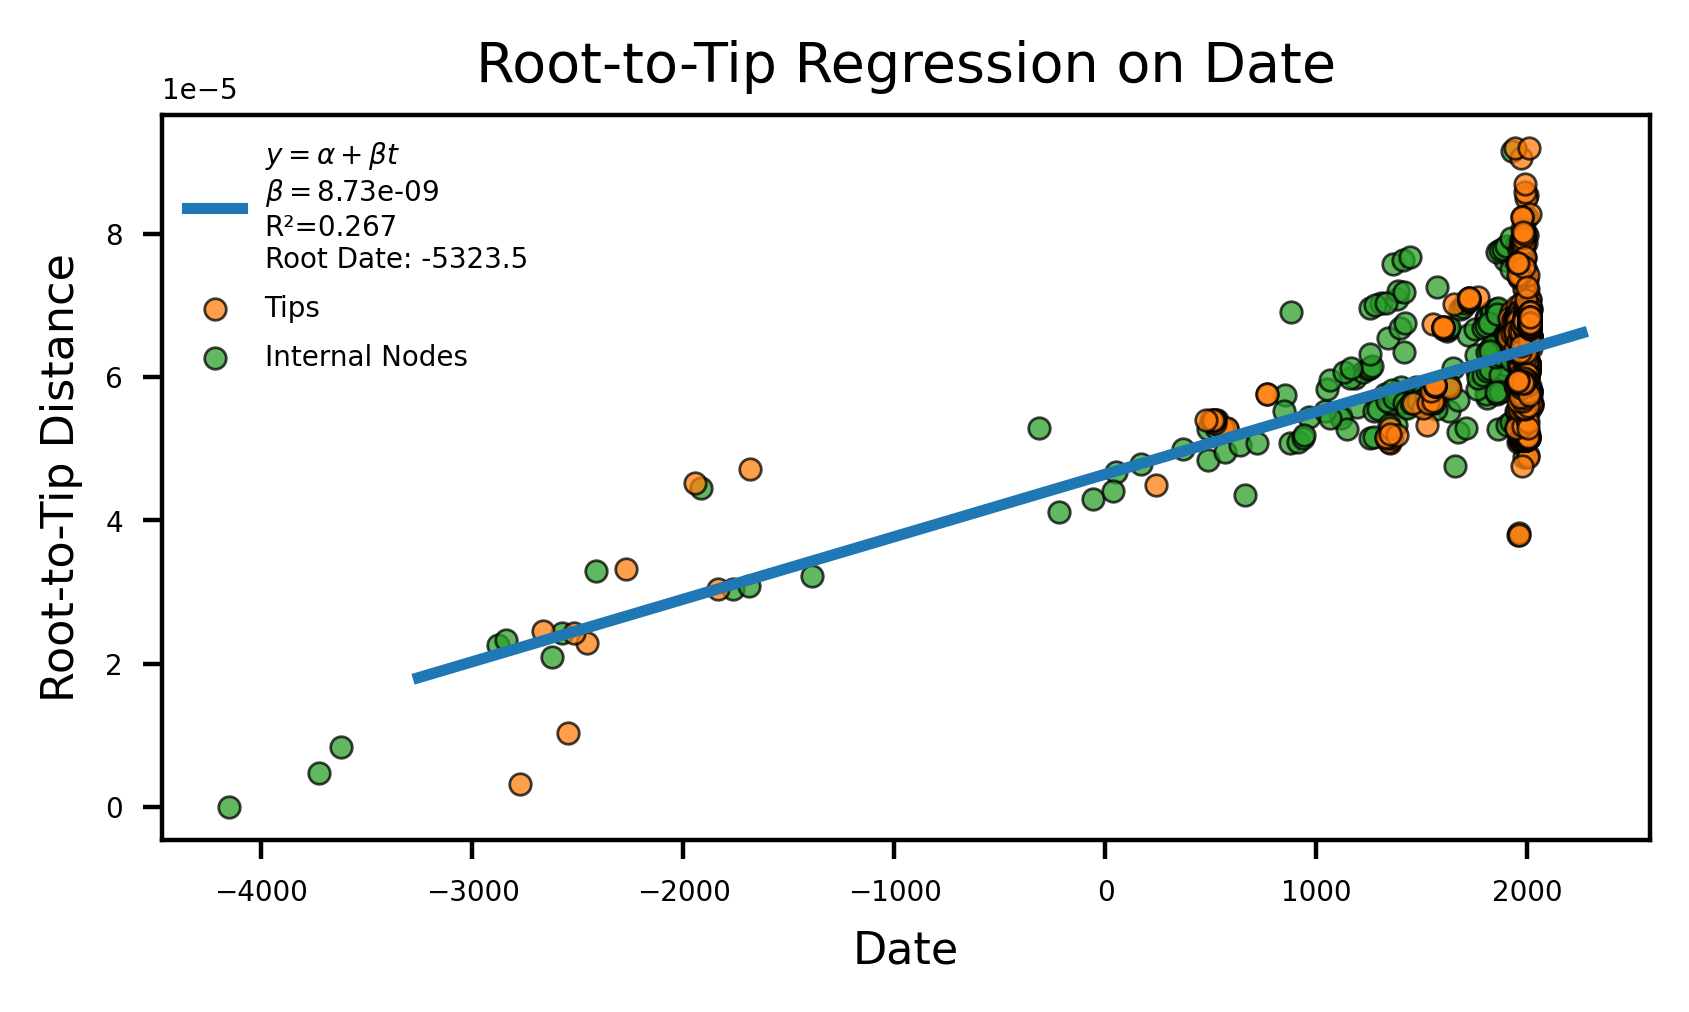

In [15]:
# Root to tip regression
fig, (ax1) = plt.subplots(1, dpi=400, figsize=figsize_mini)


tip_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) &
                   (tree_df["Branch_Support_Color"] == TERM_COL) ]

int_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) & (tree_df["Branch_Support_Color"] != TERM_COL)]

regression = tt.clock_model
t_mrca = -regression['intercept']/regression['slope']
# This does not filter for bad branches!
time_span = np.max(tip_data["timetree_reg_x"]) - np.min(tip_data["timetree_reg_x"])
x_vals = np.array([max(np.min(tip_data["timetree_reg_x"]), t_mrca) - 0.1*time_span, 
                   np.max(tip_data["timetree_reg_x"]+0.05*time_span)])

res = scipy.stats.linregress(list(tip_data["timetree_reg_x"]),list(tip_data["timetree_reg_y"]))

# When no confidence is enabled
dev_rtt = None
dev_slope = None

# Plot tips
ax1.scatter(data=tip_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Tips",
            color=DISC_CMAPLIST[1],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=2,)

# Plot internal nodes
ax1.scatter(data=int_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Internal Nodes",
            color=DISC_CMAPLIST[2],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=1,)

# Regression line
ax1.plot(x_vals, 
         regression['slope']*x_vals + regression['intercept'],
         label = r"$y=\alpha + \beta t$"+"\n"+
                r"$\beta=$%1.2e"%(regression["slope"])
                + ("+/- %1.e"%dev_slope if dev_slope else "") +
                "\nR²={:.3f}".format(res.rvalue**2) +
                "\nRoot Date: %1.1f"%(-regression['intercept']/regression['slope']) +
                ("+/- %1.2f"%dev_rtt if dev_rtt else ""),
         color=DISC_CMAPLIST[0],
        )

# Labels
ax1.set_xlabel("Date")
ax1.set_ylabel("Root-to-Tip Distance")
ax1.set_title("Root-to-Tip Regression on Date")
# Legend
plt.legend(loc=2)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

---
# 4. Plot timetreee

## Important events to label

In [16]:
tt_copy = copy.deepcopy(tt)

# Clade based events
first_pandemic_tips = list(tree_df[(tree_df["Branch_Minor"] == "0.ANT4")].index)
first_pandemic_mrca = tt_copy.tree.common_ancestor(first_pandemic_tips)

second_pandemic_tips = list(tree_df[(tree_df["Branch_Major"] == "1.PRE")].index)
second_pandemic_mrca = tt_copy.tree.common_ancestor(second_pandemic_tips)

third_pandemic_tips = list(tree_df[(tree_df["Branch_Major"] == "1.ORI")].index)
third_pandemic_mrca = tt_copy.tree.common_ancestor(third_pandemic_tips)

two_med_tips = list(tree_df[(tree_df["Branch_Major"] == "2.MED")].index)
two_med_mrca = tt_copy.tree.common_ancestor(two_med_tips)

target_attr = {"2.ANT": '', "2.MED": '', "3.ANT": "", "4.ANT": ""}
for c in tt_copy.tree.get_terminals():
    mug_val = tree_df[MUG_ATTR][c.name]
    if mug_val in target_attr and not target_attr[mug_val]:
        target_attr[mug_val] = c

big_bang_node = tt_copy.tree.common_ancestor(list(target_attr.values()))

# Sample based events
black_death_node = tt_copy.tree.common_ancestor("SAMN00715800") # black death node: 8291
justinian_plague_node = tt_copy.tree.common_ancestor("SAMEA4354665") #justinian plague node: AE1175 

## Plot div tree vs time tree

1293.11	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


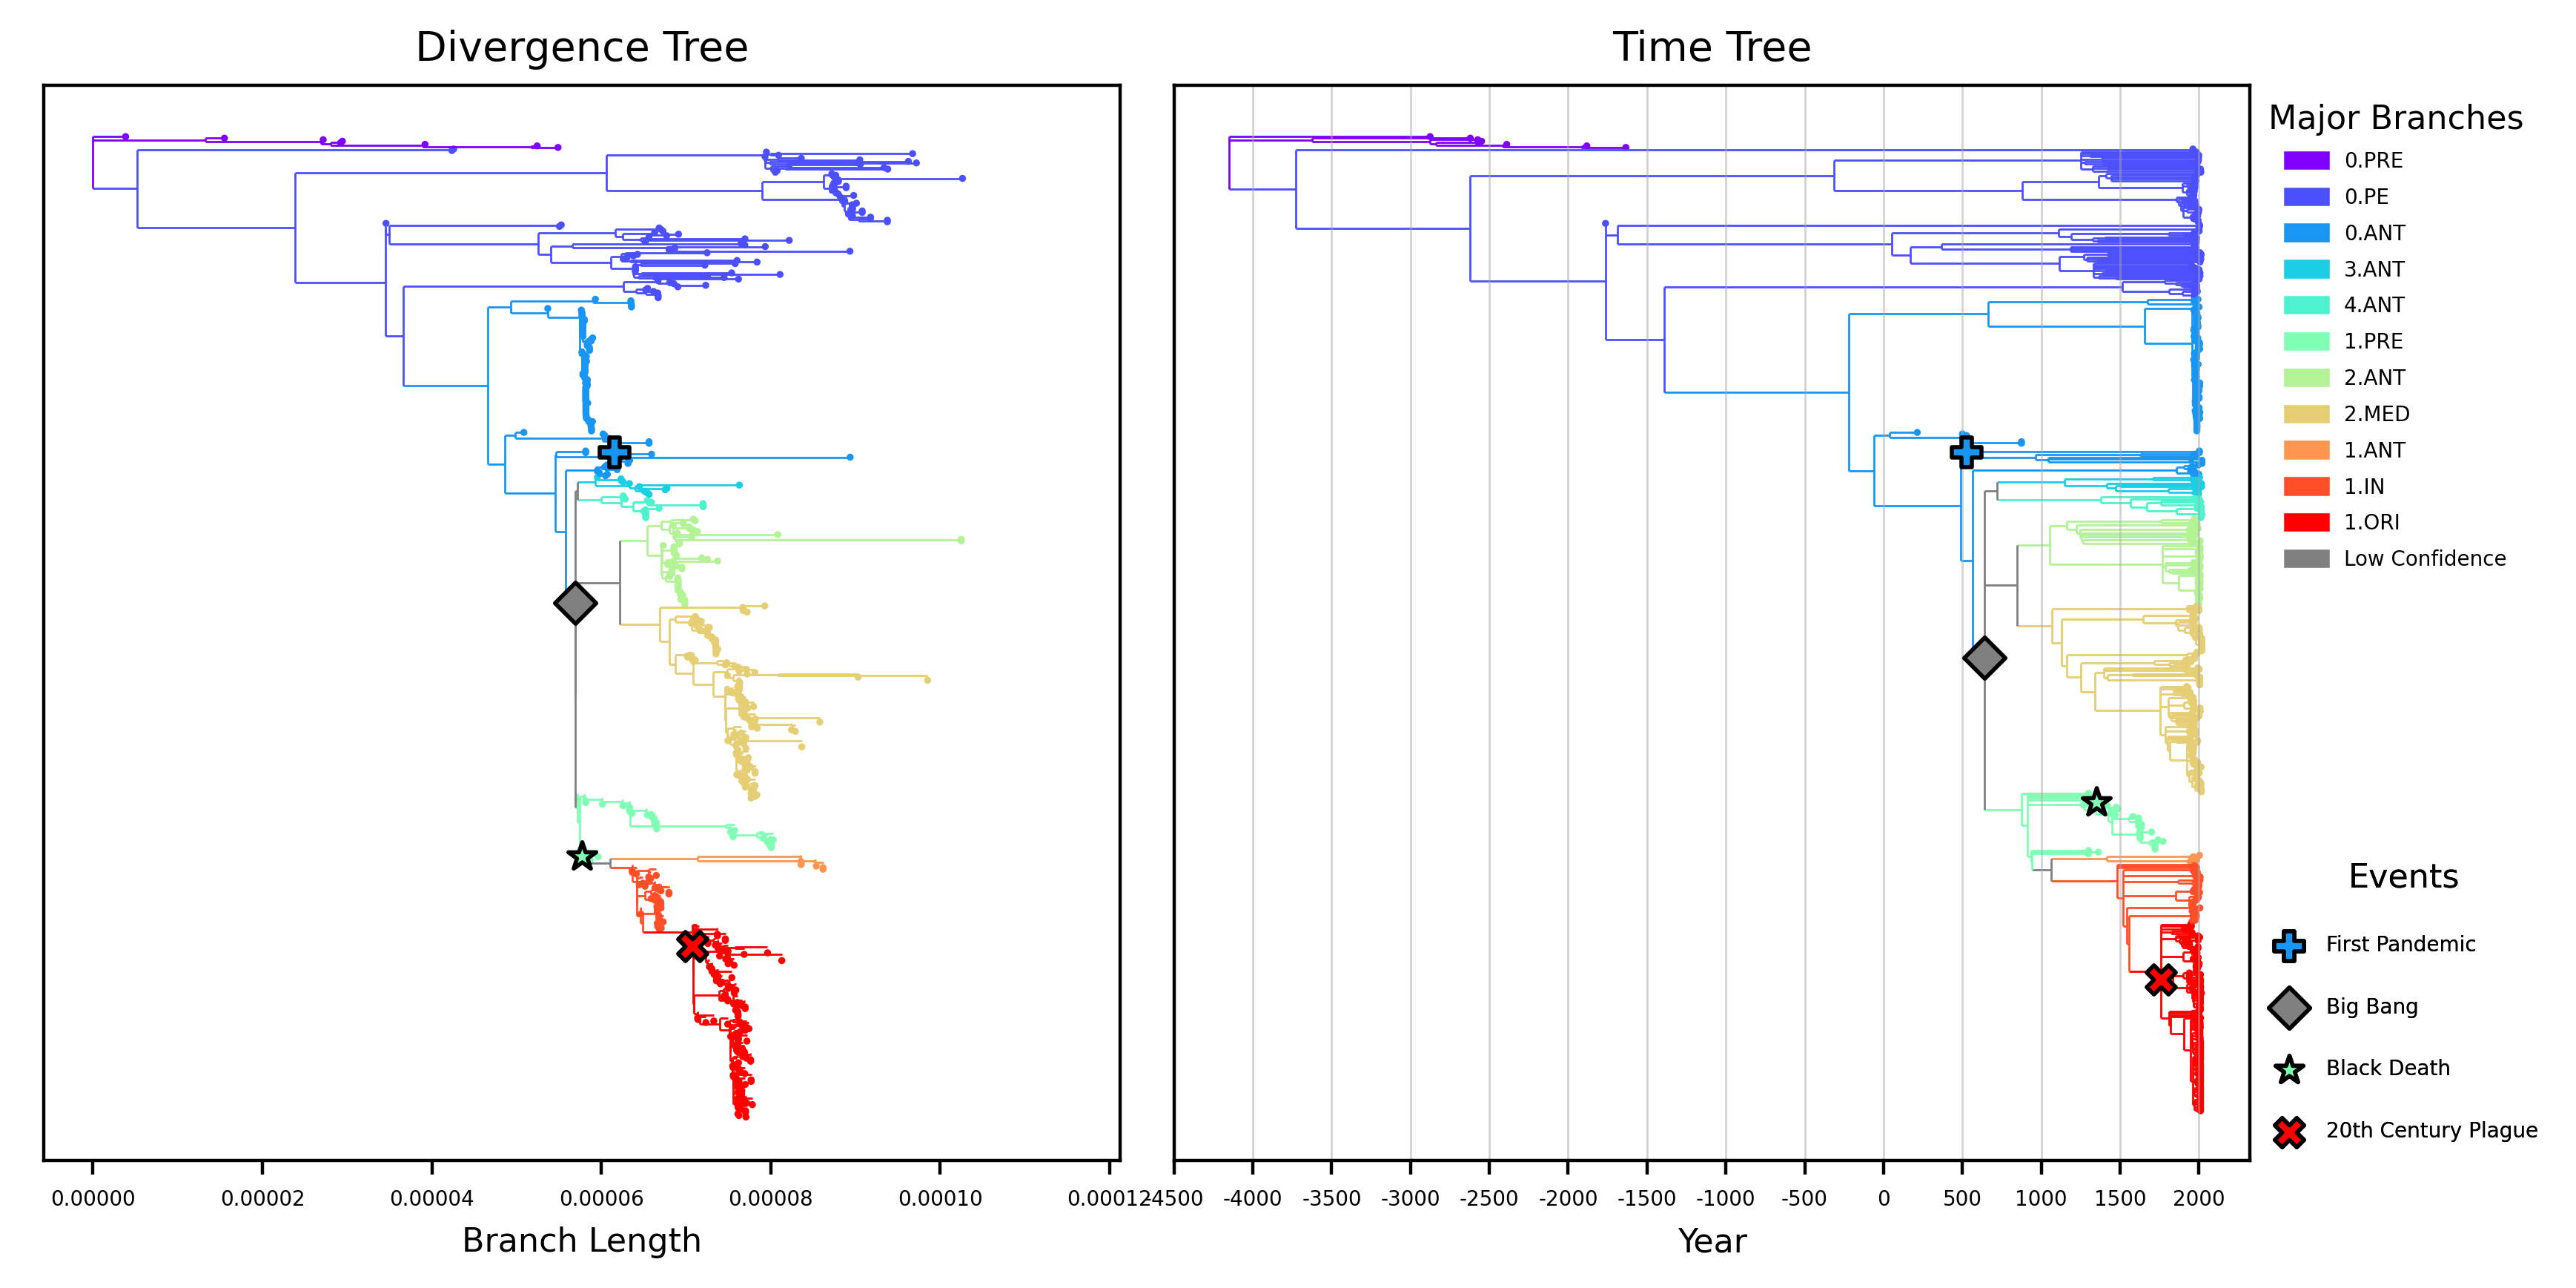

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, 
                         dpi=dpi, 
                         gridspec_kw={'wspace': 0.05}, 
                         figsize=figsize_alt,
                         sharey=True,
                         )

plt.rc('lines', linewidth=0.5)

# Create a dictionary to hold mapping of attribute : color
# Will need this later for legend construction?
mug_dict = {MUG_ATTR: {"hex_color": {}}}

# Make copies for modification
tree_div_copy = copy.deepcopy(tree_div)
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

for c in tree_div_copy.find_clades():
    c.color = "black"
# --------------------------------------------
# Draw trees
for t,ax in zip([tree_div_copy, tt_copy.tree], [ax1, ax2]):
    # Color the tree by an attribute
    hex_dict = color_tree(tree=t, 
                          df=tree_df, 
                          attribute="Mugration_" + MUG_ATTR,
                          attribute_confidence="Mugration_" + MUG_ATTR + "_Confidence",
                          threshold_confidence=MUG_CONF_THRESH,                          
                          color_pal=CONT_COLOR_PAL)
    # Add the Low confidence Element
    hex_dict["Low Confidence"] = "grey"
    mug_dict[MUG_ATTR]["hex_color"] = hex_dict
    Phylo.draw(t, 
           axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# --------------------------------------------
# Draw tips
tip_div_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
tip_time_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL) & (tree_df["timetree_coord_x"] != NO_DATA_CHAR)]

for df,ax,prefix in zip([tip_div_data, tip_time_data], [ax1, ax2], ["coord_", "timetree_coord_"]):
    tip_colors = []
    for attr in df["Mugration_" + MUG_ATTR]:
        tip_colors.append(hex_dict[attr])
    ax.scatter(data=df,
               x=prefix + "x", 
               y=prefix + "y",
               s=0.5, 
               c=tip_colors,
               label="",)

# --------------------------------------------
# Draw events
event_marker_size = 50
event_dict = {
    "First Pandemic": {
        "node": justinian_plague_node,
        "marker": "P",
        "color": mug_dict[MUG_ATTR]["hex_color"]["0.ANT"],
    }, 
    "Big Bang": {
        "node": big_bang_node,
        "marker": "D",
        "color": mug_dict[MUG_ATTR]["hex_color"]["Low Confidence"],
    },
    "Black Death" : {
        "node": black_death_node,
        "marker": "*",
        "color": mug_dict[MUG_ATTR]["hex_color"]["1.PRE"],
    },
    "20th Century Plague": {
        "node" : third_pandemic_mrca,
        "marker" : "X",
        "color": mug_dict[MUG_ATTR]["hex_color"]["1.ORI"],
    }}

for event in event_dict:
    # shift markers up
    y_shift = 5
    # plot on both axes
    ax1.scatter(
        x = tree_df["coord_x"][event_dict[event]["node"].name], 
        y = tree_df["coord_y"][event_dict[event]["node"].name] + y_shift,
        marker=event_dict[event]["marker"], 
        label=event, 
        color=event_dict[event]["color"], 
        ec="black",
        s=event_marker_size,
        zorder=3,
        )    
    ax2.scatter(
        x = tree_df["timetree_coord_x"][event_dict[event]["node"].name], 
        y = tree_df["timetree_coord_y"][event_dict[event]["node"].name] + y_shift,
        marker=event_dict[event]["marker"], 
        label=event, 
        color=event_dict[event]["color"], 
        ec="black",
        s=event_marker_size,
        zorder=3,
        )

# --------------------------------------------
# Ticks

# The y axis is not particularly meaning, remove the ticks
ax1.set_yticks([])
ax2.set_yticks([])

ticks_dict = convert_timetree_ticks(tree=tt_copy.tree, step=500)

# Set the new tick locations and labels
ax2.set_xticks(ticks_dict["tick_locs"])
ax2.set_xticklabels(ticks_dict["tick_labels"])

date_to_x = (float(ticks_dict["tick_locs"][-1]) - float(ticks_dict["tick_labels"][-1]))

# --------------------------------------------
# Confidence
"""
for rec in tree_df.iterrows():
    node_name = rec[0]
    date_conf = tree_df["timetree_" + DATE_COL + "_Confidence"][node_name]
    if date_conf != NO_DATA_CHAR:
        date_convert = [date_conf[0] + date_to_x, date_conf[1] + date_to_x ]
        date_y = tree_df["timetree_coord_y"][node_name]
        ax2.plot([date_convert[0], date_convert[1]], 
                 [date_y,date_y],
                 linewidth=1,
                 alpha=0.5,
                 color="grey",
                )
"""
# --------------------------------------------
# Labels

ax1.set_xlabel('Branch Length')
ax1.set_ylabel('')    

ax2.set_xlabel('Year')
ax2.set_ylabel('')

ax1.set_title("Divergence Tree")
ax2.set_title("Time Tree")


# --------------------------------------------
# Lines

# Vertical lines for dates
for loc in ticks_dict["tick_locs"]:
    ax2.axvline(x=loc, color="darkgrey", alpha=0.5)

# --------------------------------------------
# Limits

x_buffer = max(tree_df["coord_x"]) * 0.05
y_buffer = math.ceil(len(tree_div_copy.get_terminals()) * 0.01)

ax1.set_xlim(0 - x_buffer, max(tree_df["coord_x"]) + x_buffer)
ax1.set_ylim(len(tree_div_copy.get_terminals()) + y_buffer, 0 - y_buffer)

x_buffer = math.ceil((ticks_dict["tick_locs"][-1] - ticks_dict["tick_locs"][0]) * 0.05)
y_buffer = math.ceil(len(tt_copy.tree.get_terminals()) * 0.05)

# No x buffer on lower end
ax2.set_xlim(ticks_dict["tick_locs"][0], ticks_dict["tick_locs"][-1] + x_buffer)
ax2.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)

# --------------------------------------------
# Legends

# Make a custom patches legend for the mugration attribute
legend_mug_elements = [patches.Patch(facecolor=value, edgecolor=value,) for value in mug_dict[MUG_ATTR]["hex_color"].values()]
legend_mug_labels = list(mug_dict[MUG_ATTR]["hex_color"].keys())

legend_mug = ax2.legend(legend_mug_elements, 
           legend_mug_labels, 
           bbox_to_anchor=(1.0, 1.0), 
           loc='upper left', 
           title="Major Branches",)

legend_events = ax2.legend(bbox_to_anchor=(1.0, 0.00), 
           loc='lower left',
           title="Events",
           labelspacing=2,)

# Add multiple legends as artists
ax2.add_artist(legend_mug)
ax2.add_artist(legend_events)

# --------------------------------------------
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree_{}.{}".format(MUG_ATTR.lower(), FMT))
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
# 5. Plot Subtrees

## Setup Subtree Structure

In [20]:
subtree_dict = {
    "Second Pandemic" : {
        "tips": ["SAMN00715800","SAMEA3713715", "SAMEA5818822"], # 8291, OBS137, STN008
        "color": mug_dict[MUG_ATTR]["hex_color"]["1.PRE"],
        "node" : second_pandemic_mrca,
        "collapse": [
            {"2.MED": [], "2.ANT": []},
            {"3.ANT": [], "4.ANT": []},
            {"1.ANT": [], "1.ORI": []},            
        ],
        "step" : 50,     
    },
    "First Pandemic" : {
        "tips": ["SAMEA4354665", "SAMEA1061800"], # AE1175, DA101
        "color": mug_dict[MUG_ATTR]["hex_color"]["0.ANT"],
        "node" : first_pandemic_mrca,
        "collapse": [
            {"1.ORI": [], "0.ANT": []},
        ],
        "step" : 100,        
    },  
    "1.ORI" : {
        "tips": ["Reference"],
        "color": mug_dict[MUG_ATTR]["hex_color"]["1.ORI"],
        "node" : third_pandemic_mrca,
        "collapse": [
            {"1.IN": [],},
        ],
        "step" : 25,       
    },   
    "2.MED" : {
        "tips": two_med_tips,
        "node" : two_med_mrca,
        "collapse": [
            {"2.ANT": [],},
        ],
        "step" : 100,          
    },      
}

## Add subtree data

In [21]:
# No copying is preferred here, we use the trees modified from the previous plotting step
# Select nodes will be copied so the original tree is not collapsed

#for event_label in [list(subtree_dict.keys())[0]]:
for event_label in subtree_dict:
    # If a node was not provided, search for the mrca of the provided tips
    if not subtree_dict[event_label]["node"]:
        subtree_dict[event_label]["node"] = tt_copy.tree.common_ancestor(subtree_dict[event_label]["tips"])
    
    t = tt_copy.tree.common_ancestor(subtree_dict[event_label]["node"].name)
    # set t to the parent
    t = tt_copy.tree.get_path(t.name)[-2]
    
    # make a copy so we don't modify the original node directly
    t = copy.deepcopy(t)
               
    # --------------------------------------------
    # Collapse Undesired Clades
    if len(subtree_dict[event_label]["collapse"]) > 0:   
        # If just one collapse clade finding mrca of all        
        for collapse_clade in subtree_dict[event_label]["collapse"]:
            # Find the tips that fullfills the value criteria
            for c in t.get_terminals():
                mug_val = tree_df[MUG_ATTR][c.name]
                if mug_val in collapse_clade:
                    collapse_clade[mug_val].append(c.name)

            #target_nodes =  list(collapse_clade.values())
            target_nodes = []
            for node in collapse_clade.values():
                target_nodes += node
            if len("".join(target_nodes)) > 0:
                collapse_node = t.common_ancestor(target_nodes) 
                # Collapse all clades
                for c in collapse_node.find_clades():
                    t.collapse(target=c.name)
    
    # Replace original node in dictionary
    subtree_dict[event_label]["node"] = t    
    
    # --------------------------------------------
    # Geo - Points
    
    # Select nodes from dataset from this subtree
    t_clades = [c.name for c in t.find_clades()]
    # Temporary pandas dataframe
    df = tree_df.loc[ t_clades , : ]
    
    # Convert to geopandas dataframe
    geometry = [shapely.geometry.Point(xy) for xy in zip(df["Mugration_" + GEO_ATTR + "_Lon"], df["Mugration_" + GEO_ATTR + "_Lat"])]
    gdf = geopandas.GeoDataFrame(df, crs=CRS, geometry=geometry)
    
    # Count up the locations for sizing points
    gdf_counts = {}
    for geo in gdf["Mugration_" + GEO_ATTR]:
        if geo not in gdf_counts:
            gdf_counts[geo] = 0
        gdf_counts[geo] += 1
        
    # Store it in the dictionary
    subtree_dict[event_label]["gdf"] = gdf
    subtree_dict[event_label]["gdf_counts"] = gdf_counts 
    
    gdf_colors = []
    for node in gdf.index:
        gdf_colors.append(hex_dict[gdf["Mugration_" + MUG_ATTR][node]])
    subtree_dict[event_label]["gdf_colors"] = gdf_colors 

    # --------------------------------------------
    # Geo - Bezier
    
    gdf_bezier = {}
    # Alter the bezier curve shape
    control_factor = 0.95
    # Iterate through the terminals
    for term in t.get_terminals():

        # Initialize locations to none for each curve
        prev_loc = None
        prev_name = None

        # Force the root to be part of the path
        term_path = [t.root] + t.get_path(term.name)
        
        # Iterate through the nodes in the path from terminal to root
        for node in term_path:
            # Store the current location
            cur_loc = gdf["geometry"][node.name]
            cur_name = node.name
            # Fetch the color based on a mugration attribute
            line_color = hex_dict[gdf["Mugration_" + MUG_ATTR][node.name]]

            # If this is the root, mark it, fix up the location
            if not prev_loc:
                prev_loc = cur_loc
                prev_name = cur_name

            # If staying in place, don't store
            if prev_loc == cur_loc:
                continue

            # Westward movements are depicted by lines with an upward curvature 
            control_x = prev_loc.x
            if cur_loc.x < prev_loc.x:
                control_y = max(cur_loc.y, prev_loc.y)            
            # Eastward movements are depicted by lines with a downward curvature
            else:
                control_y = min(cur_loc.y, prev_loc.y)

            # Curved lines
            nodes = np.asfortranarray([[prev_loc.x, control_x, cur_loc.x], [prev_loc.y, control_y, cur_loc.y]])
            curve = bezier.Curve(nodes, degree=2)
            curve_conf = gdf["Mugration_" + GEO_ATTR + "_Confidence"][node.name]
            
            # Check if this curve has already been added
            if (prev_name, cur_name) not in gdf_bezier:
                gdf_bezier[(prev_name, cur_name)] = {}
                gdf_bezier[(prev_name, cur_name)]["curve"] = curve
                gdf_bezier[(prev_name, cur_name)]["conf"] = curve_conf

            prev_loc = cur_loc  
            prev_name = cur_name
    
    subtree_dict[event_label]["gdf_bezier"] = gdf_bezier
    
    # --------------------------------------------                
    # Exclude rows
    if event_label == "2.MED":
        exclude_sample = gdf[gdf["Country"] == "United States of America"].index[0]
        gdf.drop(index=exclude_sample, inplace=True)

ValueError: couldn't collapse NODE190 in this tree

## Plot subtrees

In [ ]:
for event_label in subtree_dict:
    # Get the subtree
    t = subtree_dict[event_label]["node"]
    
    fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize)
    
    # --------------------------------------------
    # Draw Tree
    # Scale line width depending on samples
    plt.rc("font", size=3)
    if len(t.get_terminals()) < 50:
        plt.rc('lines', linewidth=1)
    else:
        plt.rc('lines', linewidth=0.5)
        fig.set_size_inches(figsize[0], figsize[1] * 2)
    #label_func = lambda x: tree_df["Strain"][x.name] if tree_df["Strain"][x.name] != "NA" else ""
    #label_func = lambda x: x
    label_func = lambda x: (
        "   {} ({})".format(tree_df["Country"][x.name], tree_df["Strain"][x.name]) 
                  if tree_df["Country"][x.name] != "NA" 
                  else "({})".format(tree_df["Strain"][x.name])
                    if tree_df["Strain"][x.name] != "NA"
                  else ""
    )
    Phylo.draw(t,
               axes=ax1, 
               show_confidence=False, 
               label_func = label_func, 
               do_show=False)

    # --------------------------------------------
    # Labels
    ax1.set_xlabel("Year")
    ax1.set_ylabel("")  
    ax1.set_title(event_label)
    
    # --------------------------------------------
    # Ticks

    # The y axis is not particularly meaning, remove the ticks
    ax1.set_yticks([])

    ticks_dict = convert_timetree_ticks(tree=t, step=subtree_dict[event_label]["step"])
    ax1.set_xticklabels(ticks_dict["tick_labels"])
    ax1.set_xticks(ticks_dict["tick_locs"])

    date_to_x = float(ticks_dict["tick_labels"][-1]) - float(ticks_dict["tick_locs"][-1])

    # --------------------------------------------
    # Draw Tips

    tip_x = [c.numdate - date_to_x for c in t.get_terminals()]
    tip_y = [i for i in range(1,len(t.get_terminals())+ 1)]
    ax1.scatter(x=tip_x, 
                y=tip_y, 
                s=2, 
                c=mug_dict[MUG_ATTR]["hex_color"][event_label],
                label="",)

    # --------------------------------------------
    # Lines

    # Vertical lines for dates
    for loc in ticks_dict["tick_locs"]:
        ax1.axvline(x=loc, color="darkgrey", alpha=0.2, linewidth=0.75)

        
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['left'].set_visible(False)
    # --------------------------------------------
    # Limits
    date_range = np.max([n.numdate for n in t.get_terminals()]) - np.min([n.numdate for n in t.get_terminals()])
    x_buffer = date_range * 0.1
    y_buffer = math.ceil(len(t.get_terminals()) * 0.01)
    # No left side x_buffer
    ax1.set_xlim(ticks_dict["tick_locs"][0], 
                 ticks_dict["tick_locs"][-1] + x_buffer)
    ax1.set_ylim(len(t.get_terminals()) + y_buffer, 0 - y_buffer,)

    out_path = os.path.join(outdir, SCRIPT_NAME + "_tree_{}.{}".format(event_label.lower().replace(" ","_").replace(".","_"), FMT))
    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
# 6. Spread Map

### Plot

In [ ]:
#for event_label in [list(subtree_dict.keys())[0]]:
for event_label in subtree_dict:
    
    gdf = subtree_dict[event_label]["gdf"]
    gdf_bezier = subtree_dict[event_label]["gdf_bezier"]
    t = subtree_dict[event_label]["node"]

    fig, ax1 = plt.subplots(1,
                             dpi=dpi, 
                             figsize=figsize_mini,
                             constrained_layout=True, 
                             )

    world_polygons.plot(ax=ax1, 
                        zorder=1, 
                        alpha=0.5, 
                        color="grey",
                        edgecolor="white", 
                        linewidth=0.25,
                       )

    gdf.plot( 
                color=subtree_dict[event_label]["gdf_colors"],
                ax=ax1,
                edgecolor="black",
                linewidths=0.5,
                markersize=10,
                zorder=3,
                )
    
    
    for curve_data in gdf_bezier:
        # Line_color based on destination
        dest_name = curve_data[1]
        dest_conf = gdf_bezier[curve_data]["conf"]
        curve = gdf_bezier[curve_data]["curve"]
        line_color = hex_dict[tree_df["Mugration_" + MUG_ATTR][dest_name]]
        curve.plot(100, ax=ax1, color=line_color)
               
    
    ax1.set_xlim(region_poly[event_label]["xlim"])
    ax1.set_ylim(region_poly[event_label]["ylim"])
    
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    out_path = os.path.join(outdir, SCRIPT_NAME + "_map_{}.{}".format(event_label.lower().replace(" ","_").replace(".","_"), FMT))
    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
## Export

### Skyline plot

In [ ]:
#treetime.wrappers.print_save_plot_skyline(tt, n_std=2.0, screen=True, save=False, plot=True)
out_path_skyline_pdf = os.path.join(outdir, SCRIPT_NAME + "_skyline." + FMT )
out_path_skyline_txt = os.path.join(outdir, SCRIPT_NAME + "_skyline.tsv" )

treetime.wrappers.print_save_plot_skyline(tt, 
                                          plot=out_path_skyline_pdf, 
                                          save=out_path_skyline_txt,
                                          screen=True)

### Trees and dataframes

In [ ]:
# Save tree dataframe with clock info
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
tree_df.to_csv(out_path_df, sep="\t")

# Save timetree trees
out_path_xml = os.path.join(outdir, SCRIPT_NAME + ".xml" )
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
Phylo.write(tt.tree, out_path_xml, 'phyloxml')
Phylo.write(tt.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
Phylo.write(tt.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

### JSON

This can then be used for auspice via:

```
augur export v2 \
  --auspice-config auspice.config \
  --tree timetree.nwk \
  --node-data timetree.json \
  --output timetree_auspice.json \
  --lat-longs parse_tree_latlon.tsv \
  --color
```

In [ ]:
# There is no alignment used
node_data = {"alignment" : aln_path}
node_data["input_tree"] = tree_path

node_data['clock'] = {'rate': tt.date2dist.clock_rate,
                      'intercept': tt.date2dist.intercept,
                      'rtt_Tmrca': -tt.date2dist.intercept/tt.date2dist.clock_rate}

node_dict = {}

# Iterate through all nodes in the tree
for c in tree.find_clades():
    # Add the node to the dictionary
    node_dict[c.name] = {}
    # Iterate through all attributes in the dataframe
    for attr in tree_df.columns:
        attr_val = tree_df[attr][c.name]
        # Check if this attribute should be excluded
        exclude = False
        for keyword in COLOR_KEYWORD_EXCLUDE:
            if keyword in attr.lower():
                exclude = True    
        if not exclude:           
            # Fix numpy attr to float/int
            if type(attr_val) == np.float64:
                attr_val = float(attr_val)
            elif type(attr_val) == np.int64:               
                attr_val = int(attr_val)
            # Make attribute name in dict lowercase (ex. Branch_Length -> branch_length)
            node_dict[c.name][attr.lower()] = attr_val
            # div
            # num_date + confidence
            # raw_date

        
# Add the dataframe information to the node dict for the json
node_data["nodes"] = node_dict

out_path_json = os.path.join(outdir, SCRIPT_NAME + ".json" )
augur.utils.write_json(data=node_data, file_name=out_path_json, indent=2)

"""for node in T.find_clades():
    n_muts = len([
        position
        for ancestral, position, derived in node.mutations
        if are_sequence_states_different(ancestral, derived)
    ])

    if args.timetree:
        node_data['nodes'][node.name]['mutation_length'] = n_muts

    node_data['nodes'][node.name]['branch_length'] = n_muts"""

## Test

In [ ]:
# Root to tip regression
fig, (ax1) = plt.subplots(1, dpi=400, figsize=figsize_mini)

# Plot tips
df = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) &
                   (tree_df["Branch_Support_Color"] == TERM_COL) ]
tip_colors = []

for attr in df["Mugration_" + MUG_ATTR]:
    tip_colors.append(hex_dict[attr])
    
ax1.scatter(data=df,
               x="timetree_coord_x", 
               y="timetree_coord_y",
               s=0.5, 
               c=tip_colors,
               label="",)

ticks_dict = convert_timetree_ticks(tree=tt_copy.tree, step=500)
ax1.set_xticklabels(ticks_dict["tick_labels"])
ax1.set_xticks(ticks_dict["tick_locs"])

date_to_x = (float(ticks_dict["tick_locs"][-1]) - float(ticks_dict["tick_labels"][-1]))

tip_conf = []
for rec in df.iterrows():
    node_name = rec[0]
    date_conf = df["timetree_" + DATE_COL + "_Confidence"][node_name]
    date_convert = [date_conf[0] + date_to_x, date_conf[1] + date_to_x ]
    date_y = df["timetree_coord_y"][node_name]
    ax1.plot([date_convert[0], date_convert[1]], 
             [date_y,date_y],
             linewidth=1,
             alpha=1,
             color=DISC_CMAPLIST[0],
             zorder=3,
            )

Phylo.draw(tt_copy.tree, 
           axes=ax1, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)
